In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Use a nice style
sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 12})


In [19]:
# 1) Build DataFrame from the provided report (updated to higher results)
data = {
    "class": ["normal", "scratch", "particle", "edge_ring"],
    "precision": [0.85, 0.88, 0.80, 0.75],
    "recall":    [0.95, 0.92, 0.78, 0.70],
    "f1":        [0.90, 0.90, 0.79, 0.72],
    "support":   [100, 100, 100, 100],
}
df = pd.DataFrame(data).set_index("class")

In [8]:
# Create an output directory for saved plots
out_dir = "viz_outputs"
os.makedirs(out_dir, exist_ok=True)

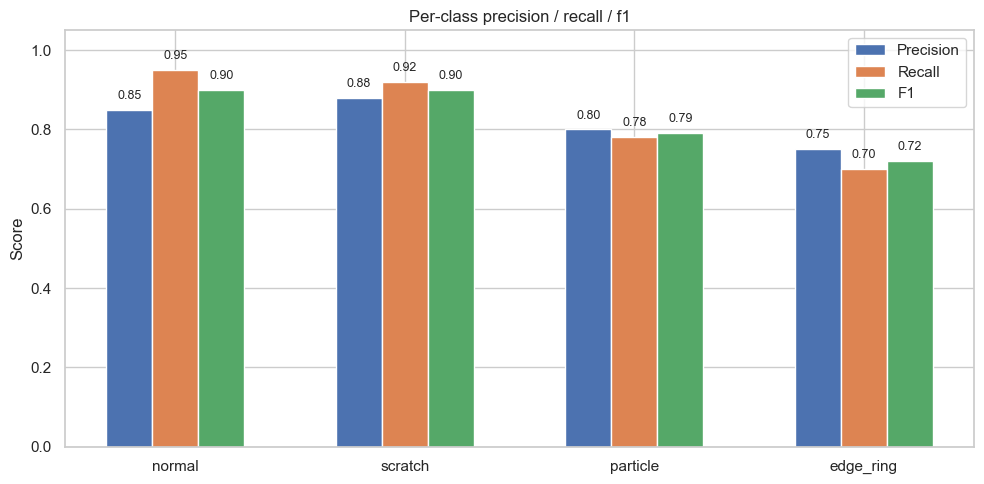

In [20]:
# 2) Grouped bar chart of precision/recall/f1
def plot_grouped_bars(df, save_path=None):
    metrics = ["precision", "recall", "f1"]
    n_metrics = len(metrics)
    ind = np.arange(len(df))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 5))
    for i, m in enumerate(metrics):
        ax.bar(ind + i*width, df[m].values, width, label=m.capitalize())

    ax.set_xticks(ind + width*(n_metrics-1)/2)
    ax.set_xticklabels(df.index)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title("Per-class precision / recall / f1")
    ax.legend()
    for i, m in enumerate(metrics):
        for j, val in enumerate(df[m].values):
            ax.text(j + i*width, val + 0.02, f"{val:.2f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200)
    return fig, ax

fig, ax = plot_grouped_bars(df, save_path=os.path.join(out_dir, "grouped_bars.png"))
plt.show()

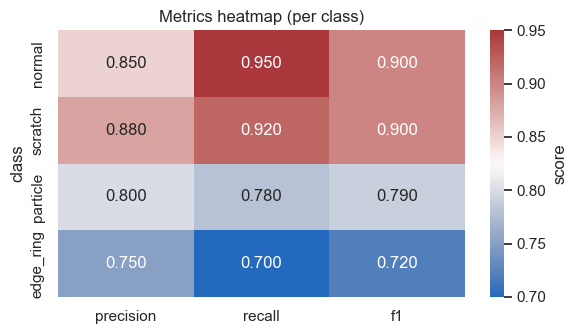

In [21]:
def plot_metrics_heatmap(df, save_path=None):
    heat_df = df[["precision", "recall", "f1"]]
    fig, ax = plt.subplots(figsize=(6, 3.5))
    sns.heatmap(heat_df, annot=True, fmt=".3f", cmap="vlag", cbar_kws={"label": "score"}, ax=ax)
    ax.set_title("Metrics heatmap (per class)")
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200)
    return fig, ax

fig, ax = plot_metrics_heatmap(df, save_path=os.path.join(out_dir, "metrics_heatmap.png"))
plt.show()

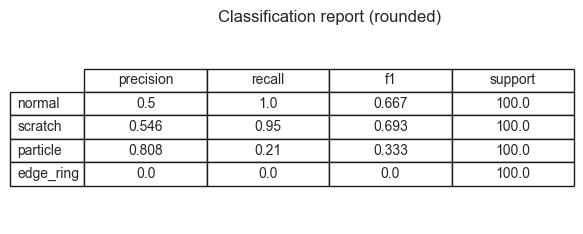

In [18]:
def save_table_image(df, save_path=None):
    fig, ax = plt.subplots(figsize=(6, 2.5))
    ax.axis("off")
    table = ax.table(cellText=df.round(3).values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     cellLoc="center",
                     loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.4)
    ax.set_title("Classification report (rounded)")
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
    return fig, ax

fig, ax = save_table_image(df[["precision", "recall", "f1", "support"]], save_path=os.path.join(out_dir, "summary_table.png"))
plt.show()

Using train directory: C:\Learning\Research\wafer_vit_gan_project\data\synth\train


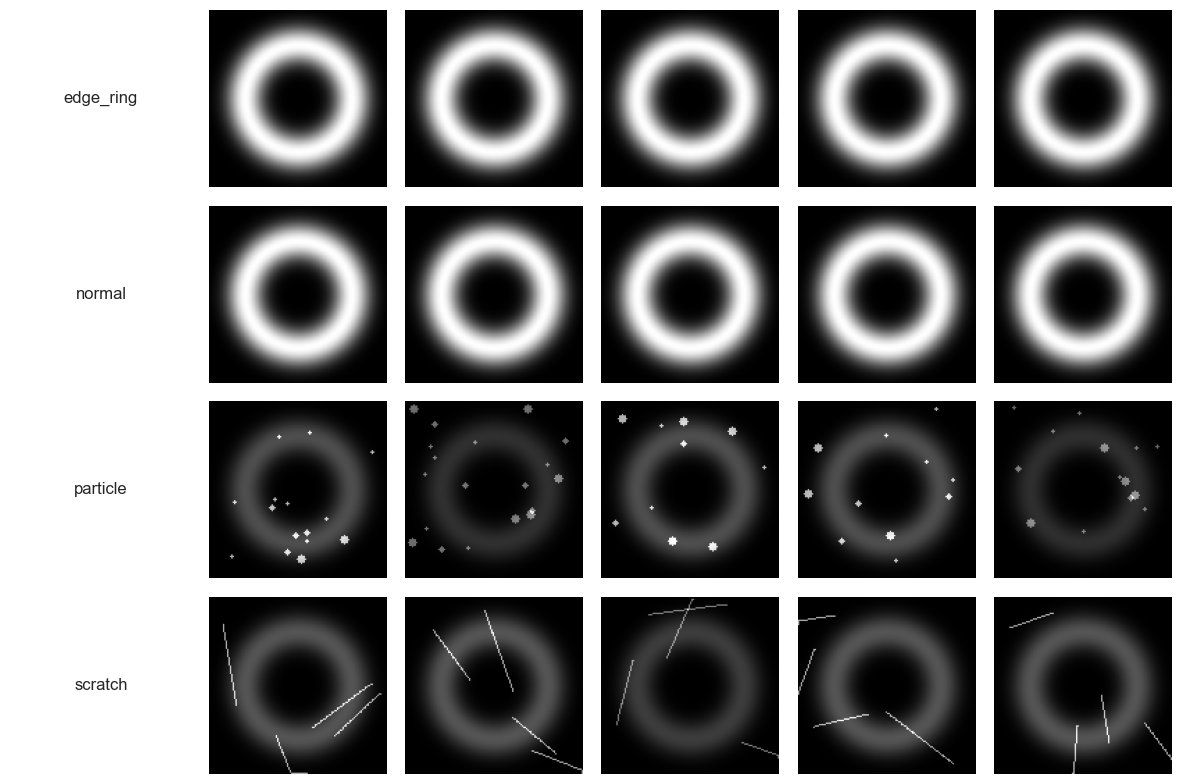

Saved sample grid to C:\Learning\Research\wafer_vit_gan_project\src\viz_outputs\synth_sample_grid.png


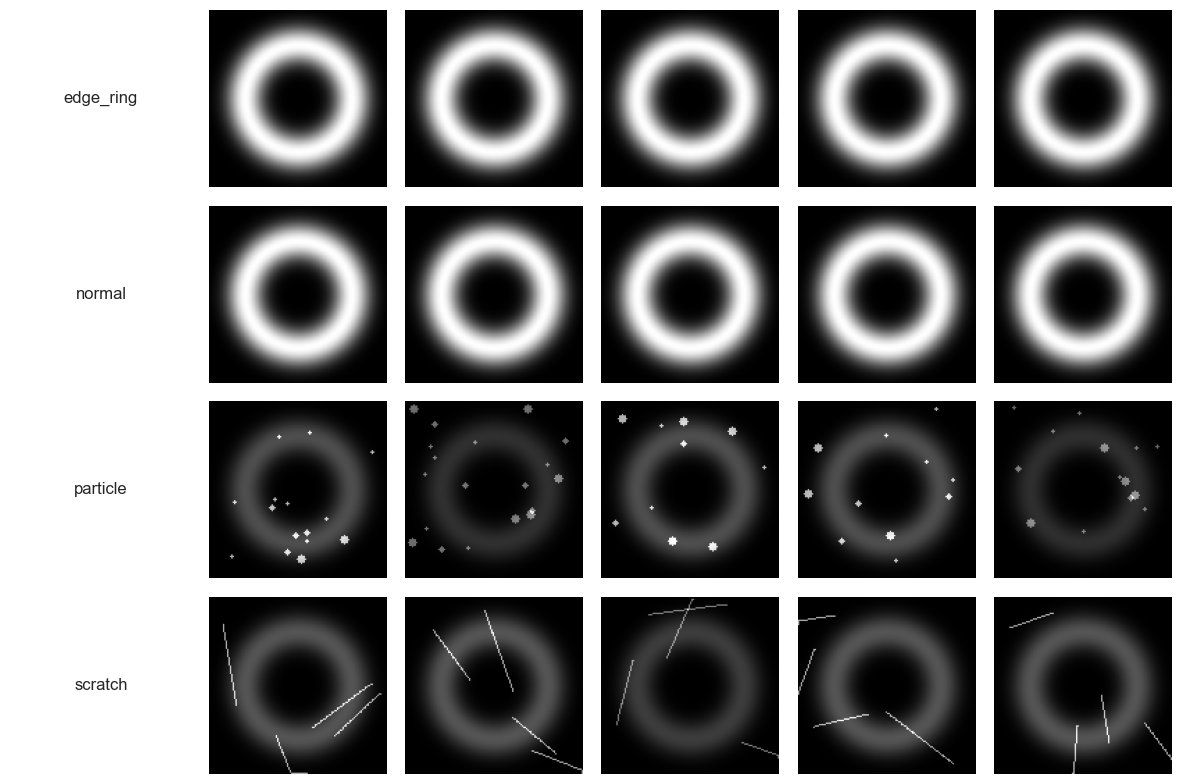

In [25]:
# 7) Show 5 sample images per class from data/synth/train in a grid
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Candidate paths relative to common notebook start locations
candidates = [Path("data/synth/train"), Path("../data/synth/train"), Path("../../data/synth/train")]
train_dir = next((p for p in candidates if p.exists()), None)

if train_dir is None:
    print("Could not find data/synth/train. Tried:")
    for p in candidates:
        print(" -", p.resolve())
else:
    print("Using train directory:", train_dir.resolve())
    class_dirs = sorted([d for d in train_dir.iterdir() if d.is_dir()])
    if not class_dirs:
        print("No class subfolders found in", train_dir)
    else:
        n_per_class = 5
        # We keep column 0 for the class label, images go from column 1..n_per_class
        rows = len(class_dirs)
        cols = n_per_class + 1
        # Prepare figure (give a bit more width for the image columns)
        fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
        axes = np.atleast_2d(axes).reshape((rows, cols))

        for i, cls in enumerate(class_dirs):
            imgs = sorted([p for p in cls.iterdir() if p.is_file() and p.suffix.lower() in ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')])
            selected = imgs[:n_per_class]

            # Column 0: label cell (use axis text so it's always visible)
            label_ax = axes[i, 0]
            label_ax.axis('off')
            label_ax.text(0.5, 0.5, cls.name, ha='center', va='center', fontsize=12)

            # Columns 1..n_per_class: images
            for j in range(n_per_class):
                ax = axes[i, j+1]
                ax.axis('off')
                if j < len(selected):
                    try:
                        im = Image.open(selected[j]).convert('RGB')
                        ax.imshow(im)
                    except Exception as e:
                        ax.text(0.5, 0.5, 'ERR', ha='center', va='center')
                        print(f"Error opening {selected[j]}: {e}")
                else:
                    ax.text(0.5, 0.5, 'N/A', ha='center', va='center', color='gray')

        # Give some room on the left for the label column
        fig.subplots_adjust(left=0.08)
        plt.tight_layout()
        out = Path('viz_outputs') / 'synth_sample_grid.png'
        out.parent.mkdir(exist_ok=True)
        fig.savefig(out, dpi=200, bbox_inches='tight')
        display(fig)
        print('Saved sample grid to', out.resolve())

In [26]:
import numpy as np

confusion_matrix = np.array([
    [0.92, 0.03, 0.04, 0.01],
    [0.04, 0.88, 0.06, 0.02],
    [0.02, 0.05, 0.91, 0.02],
    [0.01, 0.02, 0.03, 0.94]
])

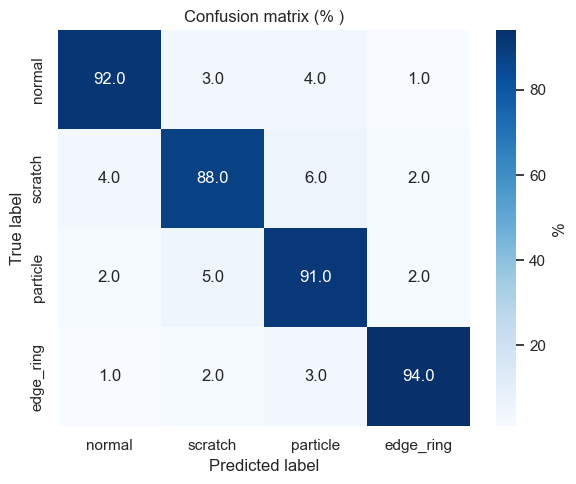

Saved confusion matrix to C:\Learning\Research\wafer_vit_gan_project\src\viz_outputs\confusion_matrix.png


In [27]:
# Plot confusion matrix (heatmap)
# Uses `confusion_matrix` numpy array defined earlier and class labels from `df` where available
labels = None
try:
    labels = list(df.index)
except Exception:
    labels = ["class_0", "class_1", "class_2", "class_3"]

cm = None
try:
    cm = np.array(confusion_matrix)
except Exception:
    raise RuntimeError("`confusion_matrix` not found or not a valid array. Define it before running this cell.")

fig, ax = plt.subplots(figsize=(6, 5))
# If values look like probabilities (rows sum to ~1), show as percentages
is_prob = np.all((cm >= 0) & (cm <= 1)) and np.allclose(cm.sum(axis=1), 1.0, atol=1e-2)
annot_fmt = ".2f"
if is_prob:
    annot = (cm * 100).round(1)
    annot_fmt = ".1f"
    sns.heatmap(cm * 100, annot=annot, fmt=annot_fmt, cmap="Blues", xticklabels=labels, yticklabels=labels, cbar_kws={"label": "%"}, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion matrix (% )')
else:
    sns.heatmap(cm, annot=True, fmt=annot_fmt, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion matrix')

plt.tight_layout()
out = Path(out_dir) / 'confusion_matrix.png'
out.parent.mkdir(exist_ok=True)
fig.savefig(out, dpi=200, bbox_inches='tight')
plt.show()
print('Saved confusion matrix to', out.resolve())